# 04 - Silver Data Analysis (Data Quality Report)

This notebook audits the generated silver NER dataset and produces a data quality report suitable for portfolio documentation.

It covers:
- split loading and summary,
- label distribution and co-occurrence,
- entity length behavior,
- source-level differences (Sanadset vs hadith-json),
- gazetteer coverage and long-tail analysis,
- class imbalance flags and mitigation suggestions.


In [1]:
from __future__ import annotations

import json
import sys
from collections import Counter, defaultdict
from itertools import combinations
from pathlib import Path
from typing import Dict, Iterable, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display


def find_project_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / 'data').exists() and (candidate / 'notebooks').exists():
            return candidate
    return start


ROOT = find_project_root(Path.cwd().resolve())
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.preprocessing.normalize import ArabicNormalizer

SILVER_DIR = ROOT / 'data' / 'silver'
SPLIT_PATHS = {
    'train': SILVER_DIR / 'train.json',
    'dev': SILVER_DIR / 'dev.json',
    'test_held_out': SILVER_DIR / 'test_held_out.json',
}
GAZETTEER_PATHS = {
    'SCHOLAR': ROOT / 'data' / 'gazetteers' / 'scholars.txt',
    'BOOK': ROOT / 'data' / 'gazetteers' / 'books.txt',
    'CONCEPT': ROOT / 'data' / 'gazetteers' / 'concepts.txt',
    'PLACE': ROOT / 'data' / 'gazetteers' / 'places.txt',
}
ENTITY_TYPES = ['SCHOLAR', 'BOOK', 'CONCEPT', 'PLACE', 'HADITH_REF']

# Set to an int (e.g. 50000) for fast exploratory runs; keep None for full analysis.
MAX_RECORDS_PER_SPLIT = None
PROGRESS_EVERY = 50_000

normalizer = ArabicNormalizer()

for split_name, path in SPLIT_PATHS.items():
    if not path.exists():
        raise FileNotFoundError(f'Missing split file: {path}')

print('Project root:', ROOT)
print('Silver dir:', SILVER_DIR)
print('Splits:')
for split_name, path in SPLIT_PATHS.items():
    print(f'  - {split_name}: {path}')
print('MAX_RECORDS_PER_SPLIT =', MAX_RECORDS_PER_SPLIT)


Project root: C:\Users\diaab\islamic-ner
Silver dir: C:\Users\diaab\islamic-ner\data\silver
Splits:
  - train: C:\Users\diaab\islamic-ner\data\silver\train.json
  - dev: C:\Users\diaab\islamic-ner\data\silver\dev.json
  - test_held_out: C:\Users\diaab\islamic-ner\data\silver\test_held_out.json
MAX_RECORDS_PER_SPLIT = None


## 1) Load Silver Splits

This section streams `train/dev/test_held_out` and computes all downstream statistics.


In [2]:
def iter_json_array(path: Path, chunk_size: int = 1 << 16):
    """Yield objects from a top-level JSON array (or JSONL fallback) without loading full file."""
    decoder = json.JSONDecoder()

    with path.open('r', encoding='utf-8') as handle:
        buffer = ''

        # Prime buffer until we have a non-whitespace character.
        while True:
            chunk = handle.read(chunk_size)
            if not chunk:
                return
            buffer += chunk
            pos0 = 0
            while pos0 < len(buffer) and buffer[pos0].isspace():
                pos0 += 1
            if pos0 < len(buffer):
                break

        # Fallback: support JSONL files by parsing one JSON object per non-empty line.
        if buffer[pos0] != '[':
            handle.seek(0)
            for line_no, line in enumerate(handle, start=1):
                text = line.strip()
                if not text:
                    continue
                try:
                    yield decoder.decode(text)
                except json.JSONDecodeError as exc:
                    raise ValueError(f'Invalid JSONL record at {path}:{line_no}: {exc}') from exc
            return

        pos = pos0 + 1

        while True:
            # Skip separators between array elements.
            while True:
                if pos >= len(buffer):
                    chunk = handle.read(chunk_size)
                    if not chunk:
                        return
                    buffer += chunk
                    continue

                ch = buffer[pos]
                if ch.isspace() or ch == ',':
                    pos += 1
                    continue
                break

            if ch == ']':
                return

            while True:
                try:
                    obj, end = decoder.raw_decode(buffer, pos)
                    yield obj
                    pos = end

                    # Trim consumed buffer periodically.
                    if pos > 1_000_000:
                        buffer = buffer[pos:]
                        pos = 0
                    break
                except json.JSONDecodeError as exc:
                    chunk = handle.read(chunk_size)
                    if not chunk:
                        context = buffer[max(0, pos - 30): min(len(buffer), pos + 60)]
                        raise ValueError(
                            f'Malformed JSON in {path} near char {pos}: {exc.msg}. Context: {context!r}'
                        ) from exc
                    buffer += chunk


def extract_entities(tokens: List[str], tags: List[str]) -> List[Dict]:
    entities = []
    n = min(len(tokens), len(tags))
    i = 0

    while i < n:
        label = tags[i]
        if label == 'O' or '-' not in label:
            i += 1
            continue

        prefix, entity_type = label.split('-', 1)
        if prefix not in {'B', 'I'}:
            i += 1
            continue

        # Treat malformed starting I-* as entity start for robustness.
        start = i
        i += 1
        while i < n and tags[i] == f'I-{entity_type}':
            i += 1

        end = i
        entities.append(
            {
                'type': entity_type,
                'start': start,
                'end': end,
                'length_tokens': end - start,
                'text': ' '.join(tokens[start:end]),
            }
        )

    return entities


def load_gazetteer_entries(path: Path) -> List[Dict]:
    entries = []
    if not path.exists():
        return entries

    for raw in path.read_text(encoding='utf-8').splitlines():
        line = raw.strip()
        if not line or line.startswith('#'):
            continue

        variants = [v.strip() for v in line.split('|') if v.strip()]
        if not variants:
            continue

        variants_norm = {normalizer.normalize(v) for v in variants if normalizer.normalize(v)}
        if not variants_norm:
            continue

        entries.append(
            {
                'canonical': variants[0],
                'variants': variants,
                'variants_norm': variants_norm,
            }
        )

    return entries


split_sentence_counts = Counter()
source_sentence_counts = Counter()
source_entity_counts = defaultdict(Counter)
source_entity_sum = Counter()
source_entity_n = Counter()

token_label_counts = Counter()
entity_count_by_type = Counter({entity_type: 0 for entity_type in ENTITY_TYPES})

cooccurrence = Counter()

entity_length_sum = Counter()
entity_length_n = Counter()
entity_length_dist = defaultdict(Counter)

observed_entities_by_type = defaultdict(set)
entity_text_counter_by_type = defaultdict(Counter)
representative_surface = defaultdict(dict)

for split_name, split_path in SPLIT_PATHS.items():
    print(f'Processing split: {split_name} -> {split_path.name}')

    for i, record in enumerate(iter_json_array(split_path), start=1):
        if MAX_RECORDS_PER_SPLIT is not None and i > MAX_RECORDS_PER_SPLIT:
            break

        tokens = record.get('tokens') or []
        tags = record.get('ner_tags') or []
        if not isinstance(tokens, list) or not isinstance(tags, list):
            continue

        n = min(len(tokens), len(tags))
        tokens = tokens[:n]
        tags = tags[:n]

        source = str(record.get('source', 'unknown'))

        split_sentence_counts[split_name] += 1
        source_sentence_counts[source] += 1
        token_label_counts.update(tags)

        entities = extract_entities(tokens, tags)
        source_entity_sum[source] += len(entities)
        source_entity_n[source] += 1

        sentence_types = sorted({e['type'] for e in entities if e['type'] in ENTITY_TYPES})
        for entity_type in sentence_types:
            cooccurrence[(entity_type, entity_type)] += 1
        for left, right in combinations(sentence_types, 2):
            cooccurrence[(left, right)] += 1
            cooccurrence[(right, left)] += 1

        for entity in entities:
            entity_type = entity['type']
            if entity_type not in ENTITY_TYPES:
                continue

            entity_count_by_type[entity_type] += 1
            source_entity_counts[source][entity_type] += 1

            length_tokens = int(entity['length_tokens'])
            entity_length_sum[entity_type] += length_tokens
            entity_length_n[entity_type] += 1
            entity_length_dist[entity_type][length_tokens] += 1

            normalized_entity_text = normalizer.normalize(entity['text'])
            if not normalized_entity_text:
                continue

            observed_entities_by_type[entity_type].add(normalized_entity_text)
            entity_text_counter_by_type[entity_type][normalized_entity_text] += 1
            representative_surface[entity_type].setdefault(normalized_entity_text, entity['text'])

        if i % PROGRESS_EVERY == 0:
            print(f'  {split_name}: processed {i:,} records...')


entity_counts_series = pd.Series({entity_type: entity_count_by_type[entity_type] for entity_type in ENTITY_TYPES})

split_counts_df = pd.DataFrame(
    {'split': list(split_sentence_counts.keys()), 'sentences': list(split_sentence_counts.values())}
).sort_values('split')

total_tokens = int(sum(token_label_counts.values()))
o_tokens = int(token_label_counts.get('O', 0))
entity_tokens = int(total_tokens - o_tokens)

token_balance_df = pd.DataFrame(
    [
        {'group': 'O', 'tokens': o_tokens, 'pct': (o_tokens / total_tokens * 100) if total_tokens else 0.0},
        {'group': 'Entity', 'tokens': entity_tokens, 'pct': (entity_tokens / total_tokens * 100) if total_tokens else 0.0},
    ]
)

label_distribution_df = pd.DataFrame(
    [
        {
            'label': label,
            'count': count,
            'pct': (count / total_tokens * 100) if total_tokens else 0.0,
        }
        for label, count in token_label_counts.items()
    ]
).sort_values('count', ascending=False)

cooccur_df = pd.DataFrame(0, index=ENTITY_TYPES, columns=ENTITY_TYPES, dtype=int)
for (left, right), value in cooccurrence.items():
    if left in cooccur_df.index and right in cooccur_df.columns:
        cooccur_df.loc[left, right] = int(value)

source_entity_df = pd.DataFrame(index=sorted(source_sentence_counts.keys()), columns=ENTITY_TYPES).fillna(0)
for source in source_entity_df.index:
    for entity_type in ENTITY_TYPES:
        source_entity_df.loc[source, entity_type] = int(source_entity_counts[source][entity_type])
source_entity_df = source_entity_df.astype(int)

source_summary_df = pd.DataFrame(
    [
        {
            'source': source,
            'sentences': int(source_sentence_counts[source]),
            'entities_total': int(source_entity_sum[source]),
            'avg_entities_per_sentence': (
                source_entity_sum[source] / source_entity_n[source] if source_entity_n[source] else 0.0
            ),
        }
        for source in sorted(source_sentence_counts.keys())
    ]
)

entity_length_avg_df = pd.DataFrame(
    [
        {
            'entity_type': entity_type,
            'avg_length_tokens': (
                entity_length_sum[entity_type] / entity_length_n[entity_type] if entity_length_n[entity_type] else 0.0
            ),
            'entity_count': int(entity_length_n[entity_type]),
        }
        for entity_type in ENTITY_TYPES
    ]
)

gazetteer_entries = {
    entity_type: load_gazetteer_entries(path)
    for entity_type, path in GAZETTEER_PATHS.items()
}

gazetteer_coverage_rows = []
for entity_type in ['SCHOLAR', 'BOOK', 'CONCEPT', 'PLACE']:
    entries = gazetteer_entries.get(entity_type, [])
    observed = observed_entities_by_type[entity_type]

    covered = 0
    for entry in entries:
        if entry['variants_norm'] & observed:
            covered += 1

    total_entries = len(entries)
    gazetteer_coverage_rows.append(
        {
            'entity_type': entity_type,
            'gazetteer_entries': total_entries,
            'covered_entries': covered,
            'coverage_pct': (covered / total_entries * 100) if total_entries else 0.0,
            'unique_entities_observed_in_data': len(observed),
        }
    )

gazetteer_coverage_df = pd.DataFrame(gazetteer_coverage_rows)

top20_by_type = {}
singleton_rows = []
for entity_type in ENTITY_TYPES:
    counter = entity_text_counter_by_type[entity_type]
    representative = representative_surface[entity_type]

    top_rows = []
    for rank, (normalized_text, count) in enumerate(counter.most_common(20), start=1):
        top_rows.append(
            {
                'rank': rank,
                'entity_normalized': normalized_text,
                'example_surface': representative.get(normalized_text, normalized_text),
                'count': int(count),
            }
        )

    top20_by_type[entity_type] = pd.DataFrame(top_rows)

    unique_entities = len(counter)
    singleton_count = sum(1 for value in counter.values() if value == 1)
    singleton_rows.append(
        {
            'entity_type': entity_type,
            'unique_entities': unique_entities,
            'singletons': singleton_count,
            'singleton_pct': (singleton_count / unique_entities * 100) if unique_entities else 0.0,
        }
    )

singleton_df = pd.DataFrame(singleton_rows)

total_entities = int(sum(entity_counts_series.values))
entity_share_df = pd.DataFrame(
    {
        'entity_type': ENTITY_TYPES,
        'count': [int(entity_counts_series[entity_type]) for entity_type in ENTITY_TYPES],
    }
)
entity_share_df['pct'] = np.where(total_entities > 0, entity_share_df['count'] / total_entities * 100, 0.0)

scholar_share = float(entity_share_df.loc[entity_share_df['entity_type'] == 'SCHOLAR', 'pct'].iloc[0])
book_share = float(entity_share_df.loc[entity_share_df['entity_type'] == 'BOOK', 'pct'].iloc[0])
imbalance_flag = scholar_share >= 80.0 and book_share <= 2.0

print()
print('Completed streaming analysis.')
print(f'Total sentences analyzed: {sum(split_sentence_counts.values()):,}')
print(f'Total tokens analyzed: {total_tokens:,}')
print(f'Total entities analyzed: {total_entities:,}')

display(split_counts_df)
display(source_summary_df)


Processing split: train -> train.json
Processing split: dev -> dev.json
Processing split: test_held_out -> test_held_out.json

Completed streaming analysis.
Total sentences analyzed: 3,603
Total tokens analyzed: 199,573
Total entities analyzed: 18,605


C:\Users\diaab\AppData\Local\Temp\ipykernel_20420\4188752384.py:250: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  source_entity_df = pd.DataFrame(index=sorted(source_sentence_counts.keys()), columns=ENTITY_TYPES).fillna(0)


,split,sentences
1,dev,360
2,test_held_out,361
0,train,2882


,source,sentences,entities_total,avg_entities_per_sentence
0,hadith_json,902,6838,7.580931
1,sanadset,2701,11767,4.356535


## 2) Label Distribution Analysis

- Entity type frequencies
- `O` vs entity token share
- Entity type co-occurrence matrix


,entity_type,count,pct
0,SCHOLAR,17466,93.877990
2,CONCEPT,942,5.063155
3,PLACE,142,0.763236
4,HADITH_REF,54,0.290245
1,BOOK,1,0.005375


,group,tokens,pct
0,O,155669,78.001032
1,Entity,43904,21.998968


,label,count,pct
0,O,155669,78.001032
2,I-SCHOLAR,25153,12.603408
1,B-SCHOLAR,17466,8.751685
3,B-CONCEPT,942,0.472008
6,B-PLACE,142,0.071152
5,I-HADITH_REF,139,0.069649
4,B-HADITH_REF,54,0.027058
7,I-CONCEPT,7,0.003507
8,B-BOOK,1,0.000501


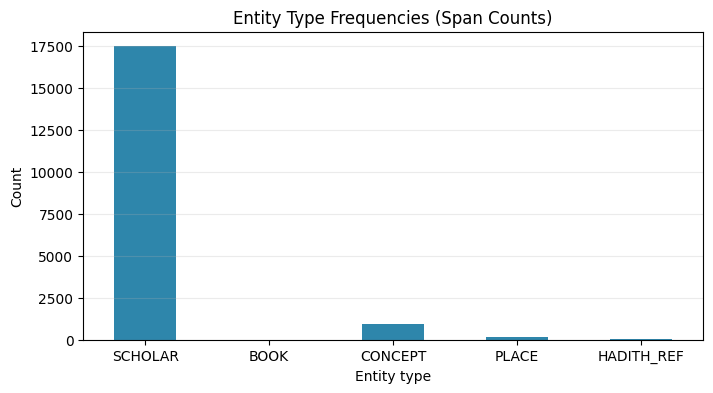

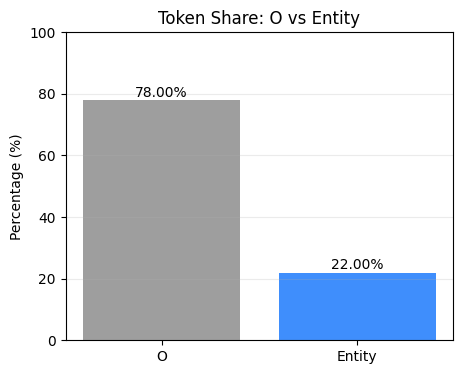

,SCHOLAR,BOOK,CONCEPT,PLACE,HADITH_REF
SCHOLAR,3598,1,659,117,40
BOOK,1,1,1,0,0
CONCEPT,659,1,663,21,9
PLACE,117,0,21,117,1
HADITH_REF,40,0,9,1,41


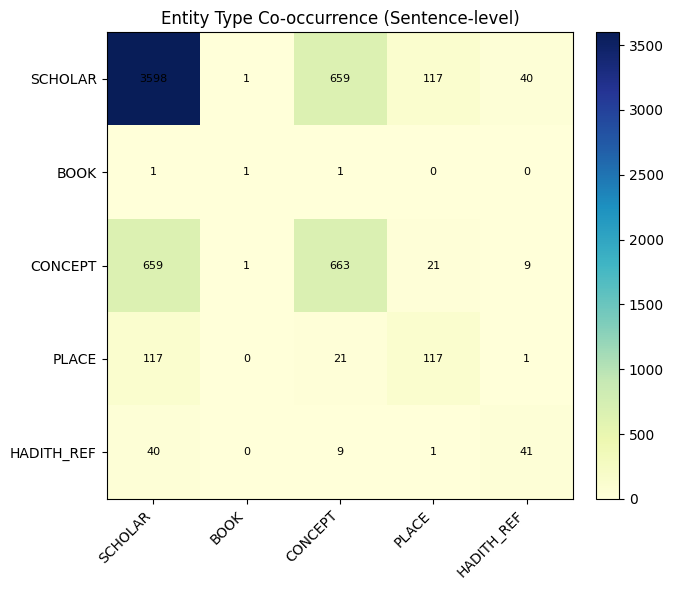

In [3]:
display(entity_share_df.sort_values('count', ascending=False))
display(token_balance_df)
display(label_distribution_df.head(20))

fig, ax = plt.subplots(figsize=(8, 4))
entity_share_df.set_index('entity_type')['count'].reindex(ENTITY_TYPES).plot(kind='bar', ax=ax, color='#2E86AB')
ax.set_title('Entity Type Frequencies (Span Counts)')
ax.set_xlabel('Entity type')
ax.set_ylabel('Count')
ax.grid(axis='y', alpha=0.25)
plt.xticks(rotation=0)
plt.show()

fig, ax = plt.subplots(figsize=(5, 4))
ax.bar(token_balance_df['group'], token_balance_df['pct'], color=['#9E9E9E', '#3F8EFC'])
ax.set_title('Token Share: O vs Entity')
ax.set_ylabel('Percentage (%)')
ax.set_ylim(0, 100)
for i, value in enumerate(token_balance_df['pct']):
    ax.text(i, value + 1, f'{value:.2f}%', ha='center', fontsize=10)
ax.grid(axis='y', alpha=0.25)
plt.show()

display(cooccur_df)

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(cooccur_df.values, cmap='YlGnBu')
ax.set_xticks(range(len(ENTITY_TYPES)))
ax.set_xticklabels(ENTITY_TYPES, rotation=45, ha='right')
ax.set_yticks(range(len(ENTITY_TYPES)))
ax.set_yticklabels(ENTITY_TYPES)
ax.set_title('Entity Type Co-occurrence (Sentence-level)')

for i in range(len(ENTITY_TYPES)):
    for j in range(len(ENTITY_TYPES)):
        ax.text(j, i, str(int(cooccur_df.iloc[i, j])), ha='center', va='center', fontsize=8)

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


## 3) Entity Length Analysis

- Average token length per type
- Distribution of lengths per entity type


,entity_type,avg_length_tokens,entity_count
0,SCHOLAR,2.440112,17466
1,BOOK,1.000000,1
2,CONCEPT,1.007431,942
3,PLACE,1.000000,142
4,HADITH_REF,3.574074,54


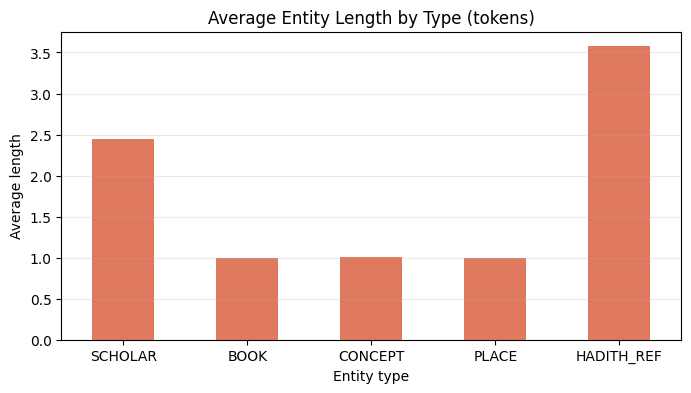

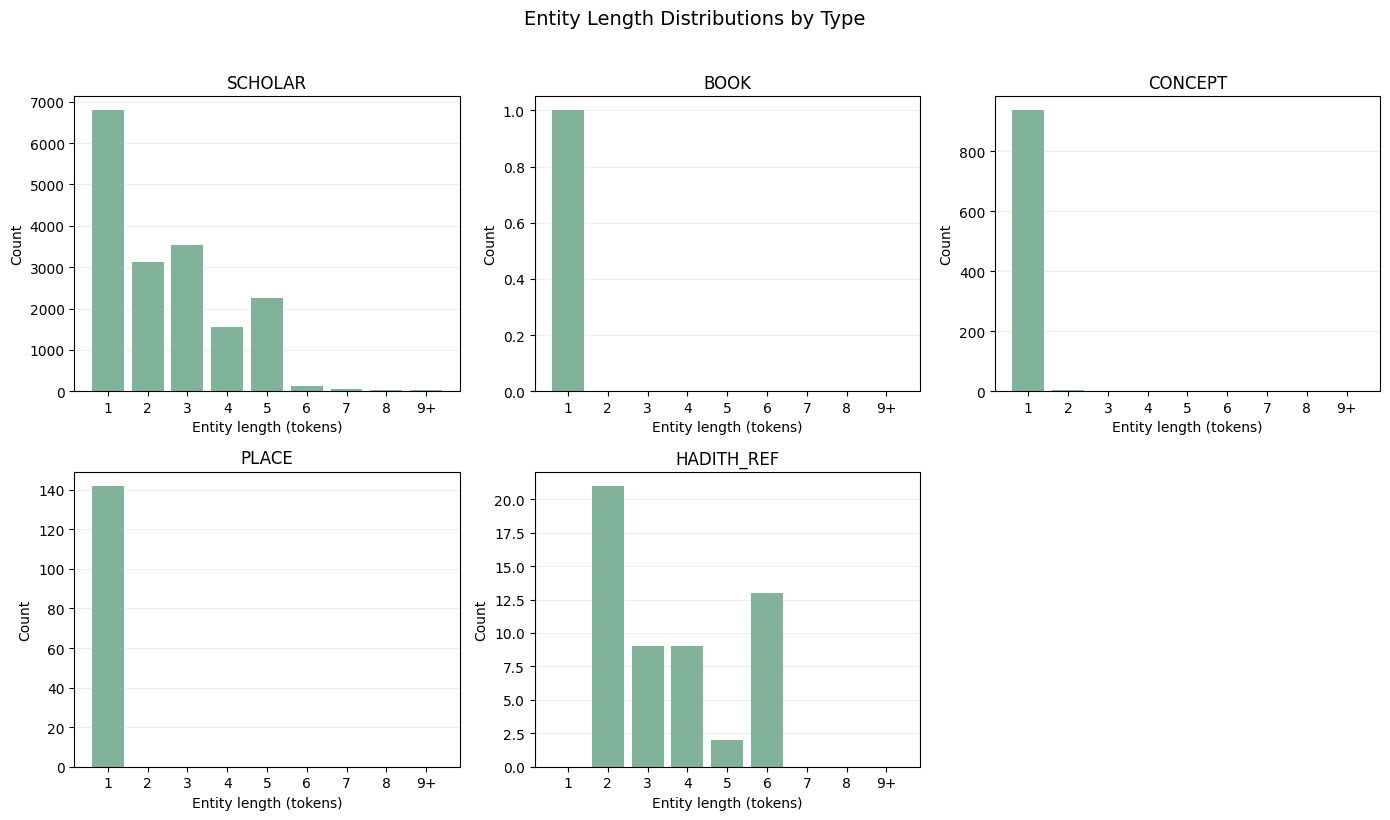

In [4]:
display(entity_length_avg_df)

fig, ax = plt.subplots(figsize=(8, 4))
entity_length_avg_df.set_index('entity_type')['avg_length_tokens'].reindex(ENTITY_TYPES).plot(
    kind='bar',
    ax=ax,
    color='#E07A5F',
)
ax.set_title('Average Entity Length by Type (tokens)')
ax.set_xlabel('Entity type')
ax.set_ylabel('Average length')
ax.grid(axis='y', alpha=0.25)
plt.xticks(rotation=0)
plt.show()


def bucket_lengths(counter: Counter, max_bucket: int = 8) -> Dict[str, int]:
    buckets = Counter()
    for length, count in counter.items():
        key = str(length) if length <= max_bucket else f'{max_bucket + 1}+'
        buckets[key] += count
    return dict(buckets)


fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for idx, entity_type in enumerate(ENTITY_TYPES):
    ax = axes[idx]
    buckets = bucket_lengths(entity_length_dist[entity_type], max_bucket=8)

    labels = [str(i) for i in range(1, 9)] + ['9+']
    values = [buckets.get(label, 0) for label in labels]

    ax.bar(labels, values, color='#81B29A')
    ax.set_title(entity_type)
    ax.set_xlabel('Entity length (tokens)')
    ax.set_ylabel('Count')
    ax.grid(axis='y', alpha=0.2)

# Hide extra subplot
axes[-1].axis('off')

plt.suptitle('Entity Length Distributions by Type', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


## 4) Source Comparison

Compare entity profiles between `sanadset` and `hadith_json` sourced sentences.


,source,sentences,entities_total,avg_entities_per_sentence
0,hadith_json,902,6838,7.580931
1,sanadset,2701,11767,4.356535


,SCHOLAR,BOOK,CONCEPT,PLACE,HADITH_REF
hadith_json,6523,1,252,45,17
sanadset,10943,0,690,97,37


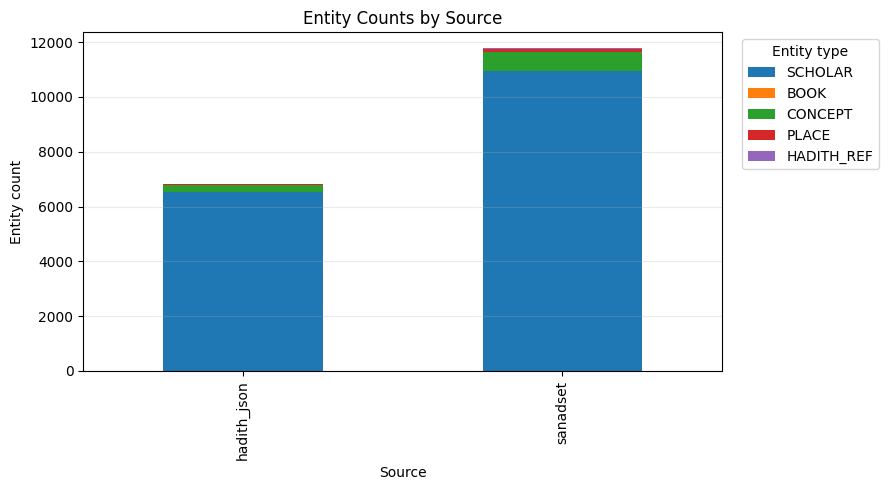

,SCHOLAR,BOOK,CONCEPT,PLACE,HADITH_REF
hadith_json,95.393390,0.014624,3.685288,0.658087,0.248611
sanadset,92.997366,0.000000,5.863857,0.824339,0.314439


SCHOLAR entities per sentence:
  sanadset: 4.051
  hadith_json: 7.232


In [5]:
display(source_summary_df)
display(source_entity_df)

fig, ax = plt.subplots(figsize=(9, 5))
source_entity_df.reindex(columns=ENTITY_TYPES).plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Entity Counts by Source')
ax.set_xlabel('Source')
ax.set_ylabel('Entity count')
ax.legend(title='Entity type', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(axis='y', alpha=0.25)
plt.tight_layout()
plt.show()

source_entity_rate_df = source_entity_df.div(source_entity_df.sum(axis=1), axis=0).fillna(0) * 100
display(source_entity_rate_df)

if {'sanadset', 'hadith_json'}.issubset(set(source_entity_df.index)):
    sanadset_row = source_entity_df.loc['sanadset']
    hadith_row = source_entity_df.loc['hadith_json']

    sanadset_scholar_per_sentence = sanadset_row['SCHOLAR'] / max(source_summary_df.loc[source_summary_df['source'] == 'sanadset', 'sentences'].iloc[0], 1)
    hadith_scholar_per_sentence = hadith_row['SCHOLAR'] / max(source_summary_df.loc[source_summary_df['source'] == 'hadith_json', 'sentences'].iloc[0], 1)

    print('SCHOLAR entities per sentence:')
    print(f"  sanadset: {sanadset_scholar_per_sentence:.3f}")
    print(f"  hadith_json: {hadith_scholar_per_sentence:.3f}")


## 5) Coverage Analysis

- Gazetteer coverage in actual silver entities
- Top 20 entities per type
- Singleton analysis (entities seen once)


In [6]:
display(gazetteer_coverage_df)
display(singleton_df)

for entity_type in ENTITY_TYPES:
    print()
    print('=' * 80)
    print(f'Top 20 entities: {entity_type}')
    if top20_by_type[entity_type].empty:
        print('No entities observed.')
    else:
        display(top20_by_type[entity_type])


,entity_type,gazetteer_entries,covered_entries,coverage_pct,unique_entities_observed_in_data
0,SCHOLAR,236,197,83.474576,4657
1,BOOK,26,0,0.000000,1
2,CONCEPT,34,28,82.352941,79
3,PLACE,10,5,50.000000,12


,entity_type,unique_entities,singletons,singleton_pct
0,SCHOLAR,4657,3272,70.259824
1,BOOK,1,1,100.000000
2,CONCEPT,79,27,34.177215
3,PLACE,12,2,16.666667
4,HADITH_REF,47,42,89.361702



Top 20 entities: SCHOLAR


,rank,entity_normalized,example_surface,count
0,1,علي,علي,437
1,2,رسول الله صلي الله عليه,رسول الله صلي الله عليه,331
2,3,مالك,مالك,308
3,4,ابيه,ابيه,302
4,5,النبي صلي الله عليه وسلم,النبي صلي الله عليه وسلم,284
5,6,ابراهيم,ابراهيم,247
6,7,سفيان,سفيان,223
7,8,قتاده,قتاده,178
8,9,مجاهد,مجاهد,155
9,10,ابي هريره,ابي هريره,153



Top 20 entities: BOOK


,rank,entity_normalized,example_surface,count
0,1,رجل,رجل,1



Top 20 entities: CONCEPT


,rank,entity_normalized,example_surface,count
0,1,الصلاه,الصلاه,140
1,2,الجنه,الجنه,107
2,3,صلاه,صلاه,94
3,4,النار,النار,61
4,5,الحج,الحج,58
5,6,الاسلام,الاسلام,40
6,7,الصدقه,الصدقه,32
7,8,الايمان,الايمان,30
8,9,زكاه,زكاه,23
9,10,حج,حج,22



Top 20 entities: PLACE


,rank,entity_normalized,example_surface,count
0,1,المدينه,المدينه,50
1,2,مكه,مكه,43
2,3,الشام,الشام,19
3,4,الكوفه,الكوفه,8
4,5,مكه،,مكه،,6
5,6,البصره,البصره,4
6,7,المدينه،,المدينه،,3
7,8,دمشق,دمشق,3
8,9,مكه‏.‏,مكه‏.‏,2
9,10,المدينه‏.‏,المدينه‏.‏,2



Top 20 entities: HADITH_REF


,rank,entity_normalized,example_surface,count
0,1,كتاب الله,كتاب الله,4
1,2,كتاب عمر,كتاب عمر,2
2,3,كتاب نقرؤه الا,كتاب نقرؤه الا,2
3,4,كتاب الله،,كتاب الله،,2
4,5,"باب ابي بكر ‏""‏‏.‏","باب ابي بكر ‏""‏‏.‏",2
5,6,كتاب كتبه عمر اليهم,كتاب كتبه عمر اليهم,1
6,7,كتاب امير المؤمنين,كتاب امير المؤمنين,1
7,8,باب معاويه,باب معاويه,1
8,9,باب الملك,باب الملك,1
9,10,كتاب الله من المؤمنين والمهاجرين سوره,كتاب الله من المؤمنين والمهاجرين سوره,1


## 6) Potential Issues and Mitigation

Flags imbalance risks and proposes practical mitigation options for training.


In [7]:
display(entity_share_df)

print('Class imbalance checks:')
print(f"- SCHOLAR share: {scholar_share:.2f}%")
print(f"- BOOK share: {book_share:.2f}%")
print(f"- Imbalance flag (SCHOLAR >= 80% and BOOK <= 2%): {imbalance_flag}")

rare_type_rows = entity_share_df[entity_share_df['pct'] < 5.0].copy()
if rare_type_rows.empty:
    print()
    print('No entity type under 5%.')
else:
    print()
    print('Entity types under 5% of all entities:')
    display(rare_type_rows.sort_values('pct'))

print()
print('Suggested mitigation actions:')
mitigations = []

if imbalance_flag:
    mitigations.append('Oversample sentences containing BOOK entities during training batches.')
    mitigations.append('Use class-weighted loss or focal loss to reduce SCHOLAR dominance.')
    mitigations.append('Track per-class F1 and accept lower BOOK F1 only with explicit reporting.')

if not rare_type_rows.empty:
    mitigations.append('Create targeted mini-corpora for low-frequency classes (BOOK/PLACE/HADITH_REF).')

if singleton_df['singleton_pct'].max() > 60:
    mitigations.append('High singleton tail detected: prefer subword-aware models and contextual augmentation.')

if not mitigations:
    mitigations.append('Current class balance is acceptable; proceed with standard stratified training.')

for idx, item in enumerate(mitigations, start=1):
    print(f'{idx}. {item}')

print()
print('Data quality report cell completed.')


,entity_type,count,pct
0,SCHOLAR,17466,93.877990
1,BOOK,1,0.005375
2,CONCEPT,942,5.063155
3,PLACE,142,0.763236
4,HADITH_REF,54,0.290245


Class imbalance checks:
- SCHOLAR share: 93.88%
- BOOK share: 0.01%
- Imbalance flag (SCHOLAR >= 80% and BOOK <= 2%): True

Entity types under 5% of all entities:


,entity_type,count,pct
1,BOOK,1,0.005375
4,HADITH_REF,54,0.290245
3,PLACE,142,0.763236



Suggested mitigation actions:
1. Oversample sentences containing BOOK entities during training batches.
2. Use class-weighted loss or focal loss to reduce SCHOLAR dominance.
3. Track per-class F1 and accept lower BOOK F1 only with explicit reporting.
4. Create targeted mini-corpora for low-frequency classes (BOOK/PLACE/HADITH_REF).
5. High singleton tail detected: prefer subword-aware models and contextual augmentation.

Data quality report cell completed.
